In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm

In [3]:
class SinteticDataset(torch.utils.data.Dataset):
    def __init__(self, directory, subwindow=None,
                 transform=None, D=1, skip=1):
        # D - Number of datas to retrieve. 
        # skip - interval between observations
        # skip = 1 we get every observation
        # skip = 2 every other observation

        self.directory = directory
        self.subwindow = subwindow  # Proportion of subwindow
        self.files = [f for f in os.listdir(directory) if '.npy' in f] #All available files
        self.D = D
        self.skip = skip
        self.Nx = (40*2)*2
        self.Ny = (68*2)*2
        self.valid_index = self.calcular_indices_validos()


    def __len__(self):
        return len(self.valid_index)

    def __getitem__(self, idx, subwindow=None):
        idx = self.valid_index[idx]
        file = idx//150
        data = np.load(self.directory + "/" + self.files[file])
        if file>0:
            idx = idx-file*150
        psi1 = data[0:150]
        psi2 = data[150:]
        psi1 = data[idx: idx + self.D*self.skip: self.skip]
        psi2 = data[idx: idx + self.D*self.skip: self.skip]
        if subwindow is None:
            subwindow = self.subwindow

        Ny_mesh, Nx_mesh = torch.meshgrid(torch.arange(self.Ny),torch.arange(self.Nx))
        lat_idx, lon_idx = self.get_indices_from_proportion(Ny_mesh, Nx_mesh, subwindow)
        # if subwindow == None
        # len(Ny_mesh) == Ny
        # len(Nx_mesh) == Nx
        # lat_idx = [0, Ny]
        # lon_idx = [0, Nx]


        psi1 = torch.tensor(psi1.reshape(psi1.shape[0],
                                         self.Ny,self.Nx)[:,
                                                     lat_idx[0]:lat_idx[1], 
                                                     lon_idx[0]:lon_idx[1]])
        #if subwindow == None,
        #ps1 has size (ps1.shape[0], Ny, Nx)
        
        psi2 = torch.tensor(psi2.reshape(psi2.shape[0],
                                         self.Ny,self.Nx)[:,
                                                     lat_idx[0]:lat_idx[1],
                                                     lon_idx[0]:lon_idx[1]])
        # if subwindow == None 
        # ps2 has size (ps2.shape[0], Ny, Nx)

        return torch.permute(torch.stack([psi1,psi2]), (1,0,2,3))
        # [D, psis, NY, NX]
        return self.prepare_tensors(u_velocity, v_velocity, ssh, mask, sliced_latitudes, sliced_longitudes)
    

    def get_indices_from_proportion(self, latitudes, longitudes, subwindow):
        if subwindow:
            lat_range = [int(subwindow[0][0] * len(latitudes)), int(subwindow[0][1] * len(latitudes))]
            lon_range = [int(subwindow[1][0] * len(longitudes)), int(subwindow[1][1] * len(longitudes))]
            return lat_range, lon_range
        return [0, len(latitudes)], [0, len(longitudes)]
    
    """
    def prepare_tensors(self, u_velocity, v_velocity, ssh, mask, latitudes, longitudes):
        u_tensor = torch.tensor(u_velocity.filled(0.0), dtype=torch.float32)
        v_tensor = torch.tensor(v_velocity.filled(0.0), dtype=torch.float32)
        ssh_tensor = torch.tensor(ssh.filled(0.0), dtype=torch.float32)
        combined_tensor = torch.stack([u_tensor, v_tensor, ssh_tensor])
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        # Creating tensors for the latitude and longitude slices
        lat_tensor = torch.tensor(latitudes, dtype=torch.float32)
        lon_tensor = torch.tensor(longitudes, dtype=torch.float32)

        return mask_tensor, combined_tensor, lat_tensor, lon_tensor
    """
    
    def calcular_indices_validos(self):
        block_size = 150
        total_size = block_size*len(self.files)
        
        # Lista para armazenar os índices válidos
        valid_indices = []
        
        # Percorre todos os índices possíveis
        for start in range(total_size):
            # Calcula os índices da sequência
            indices = [start + i * self.skip for i in range(self.D)]
            # print(indices)
            # Verifica se o último índice é válido dentro do tamanho total
            if indices[-1] >= total_size:
                continue

            # Determina o bloco do índice inicial e final
            start_block = start // block_size
            end_block = indices[-1] // block_size
            # print('startbloc = ', start_block)
            # print('end = ', end_block)
            # Verifica se o bloco inicial e final são iguais
            if start_block != end_block:
                continue
            
            # Adiciona o índice inicial à lista de válidos se todas as condições forem satisfeitas
            valid_indices.append(start)
        
        return valid_indices

class ContiguousSinteticDatasetAutoregressive(SinteticDataset):
    def __getitem__(self, idx, subwindow=None):
        tensors = super().__getitem__(idx, subwindow)
        x = tensors[-1]
        y = {'y': tensors[:-1].reshape(-1,tensors.size(-2),tensors.size(-1))}
        return x, y

In [4]:
def plotField2(ax, psi, Lx, Ly):
    x = np.linspace(0, Lx, psi.shape[0])
    y = np.linspace(0, Ly, psi.shape[1])
    X, Y = np.meshgrid(x, y)
    levels = np.linspace(-2.5, 2.5, 10)
    # ax.set_cmap('bwr')
    contour = ax.contourf(X, Y, np.transpose(psi), levels=levels, cmap = 'bwr')
    plt.colorbar(contour, ax=ax) #, label='Value')

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: > <Axes: > <Axes: >]


IndexError: index 20 is out of bounds for axis 0 with size 20

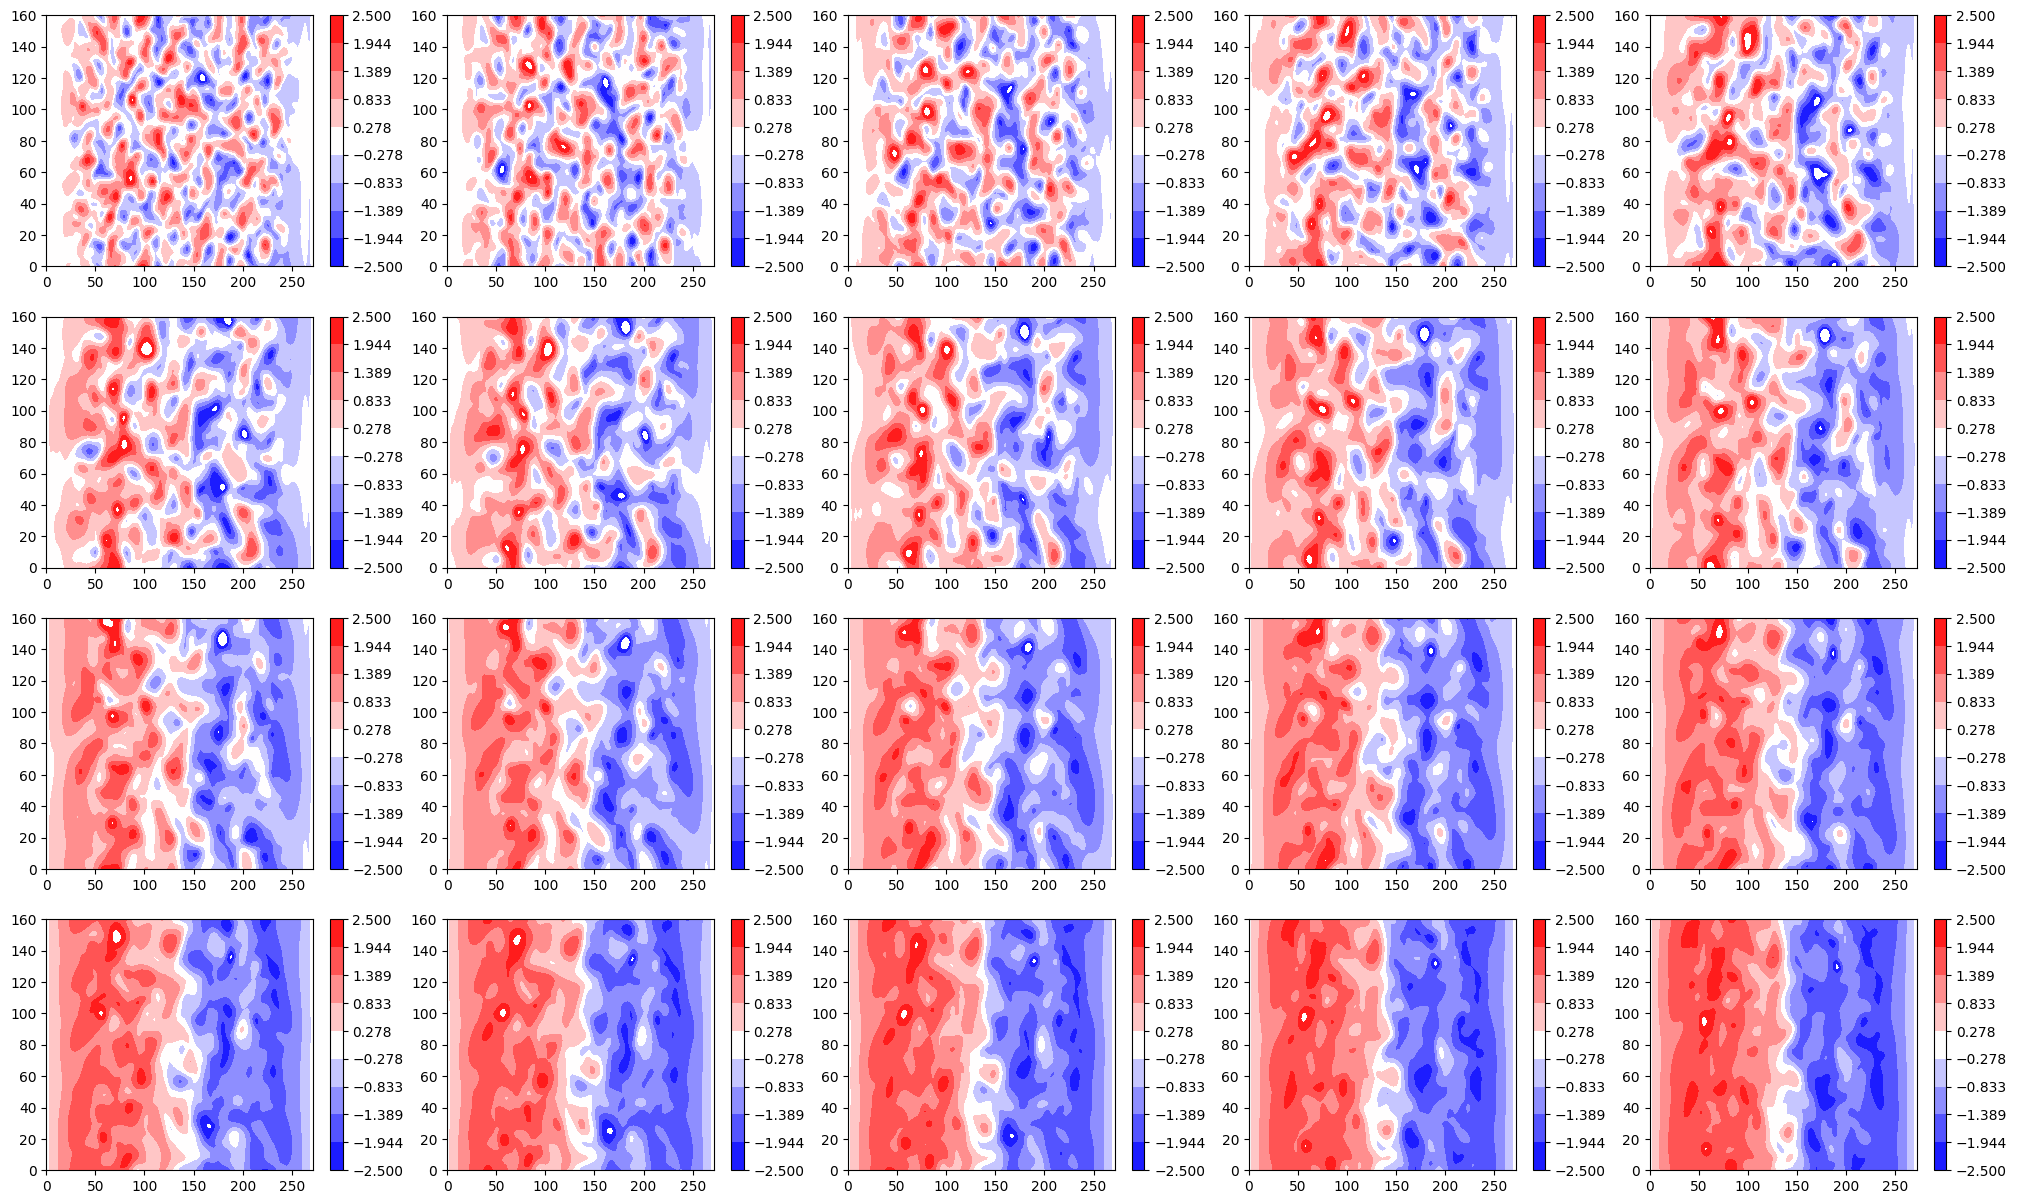

In [45]:
path = "../data/raw"

data = ContiguousSinteticDatasetAutoregressive(path, D = 70)

data = data[10]
data = data[1]['y']

psi1 = data[::2]
psi2 = data[1::2]
psi1.shape, psi2.shape

fig, axs = plt.subplots(4, 5, figsize = (25, 15))

axs = np.array(axs).flatten()
print(axs)
for i, phi in enumerate(psi1[::len(psi1)//20]):
    plotField2(axs[i], phi, phi.size(-2), phi.size(-1))

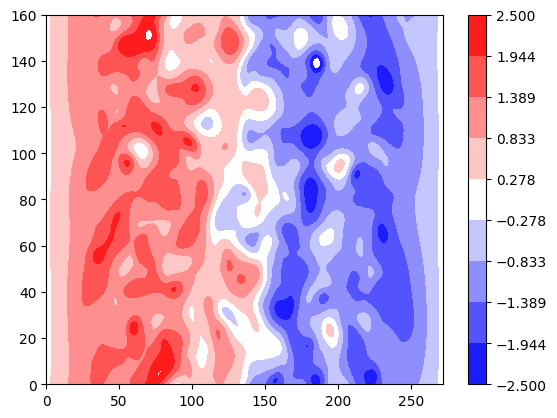

In [12]:
fig, ax = plt.subplots(1, 1)

plotField2(ax, psi1[-30], psi1[0].size(-2), psi1[0].size(-1))

### Refactor, easier way to plot data

In [46]:
Nx = (40*2)*2
Ny = (68*2)*2

In [47]:
data = SinteticDataset(path, D = 70)
data[0].shape

torch.Size([70, 2, 272, 160])

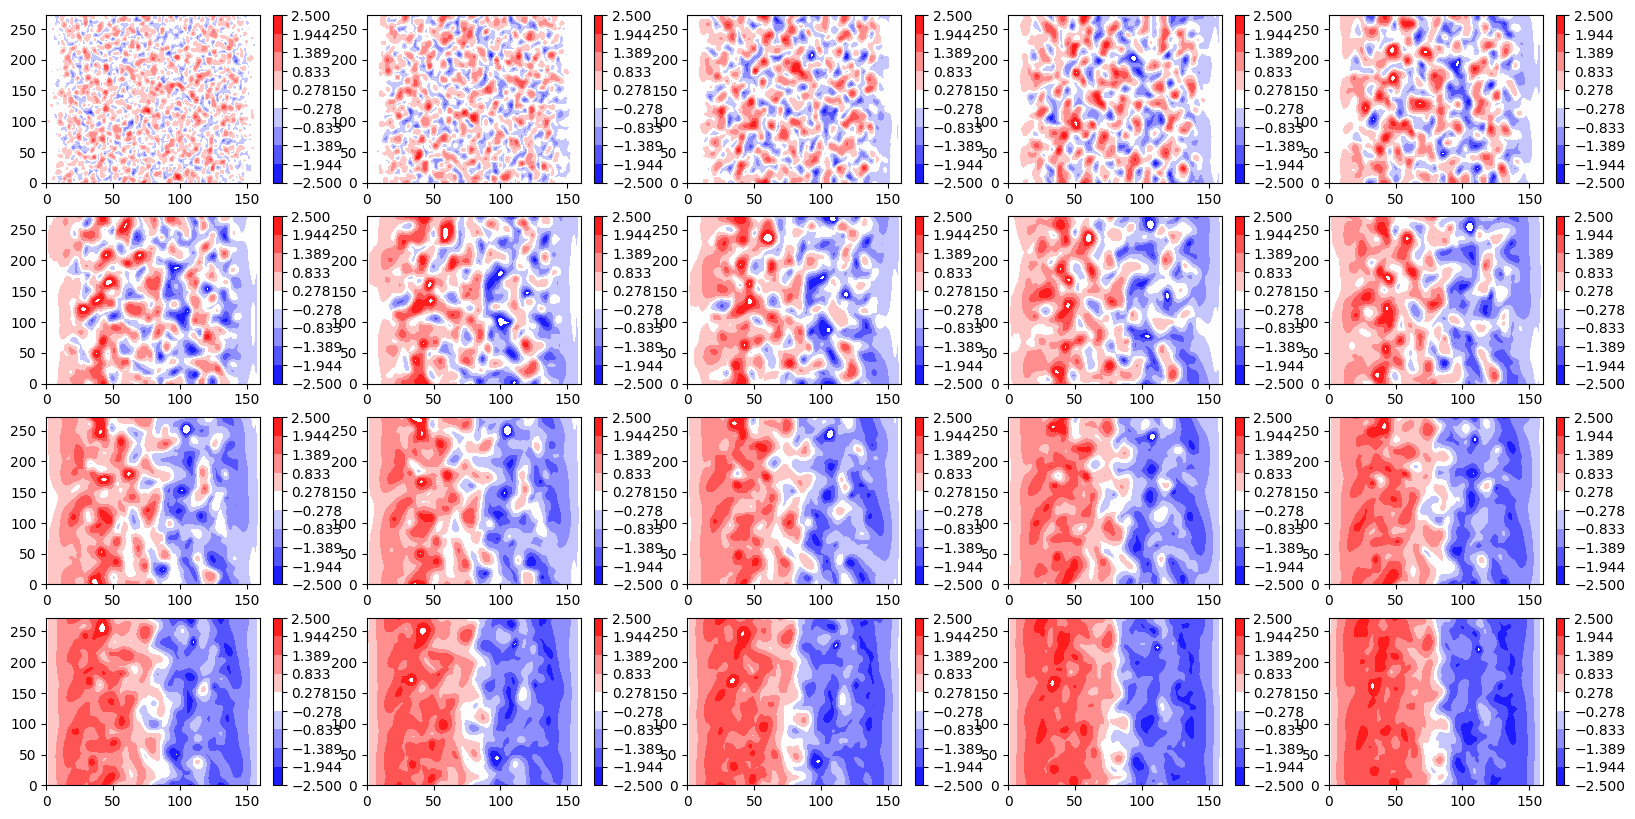

In [48]:
data[0].shape
#[D, [phi1,phi2], Ny, Nx]


fig, axs = plt.subplots(4,5, figsize = (20,10))
ax = np.array(axs).flatten()

for i in range(20):
    p = data[i * 70//20][1][0]

    x = np.linspace(0, Nx, p.shape[0])
    y = np.linspace(0, Ny, p.shape[1])
    X, Y = np.meshgrid(x, y)
    levels = np.linspace(-2.5, 2.5, 10)
    # ax[i].set_cmap('bwr')
    contour = ax[i].contourf(X, Y, np.transpose(p), levels=levels, cmap = 'bwr')
    plt.colorbar(contour, ax=ax[i]) #, label='Value')

torch.Size([34, 20])
torch.Size([272, 160])


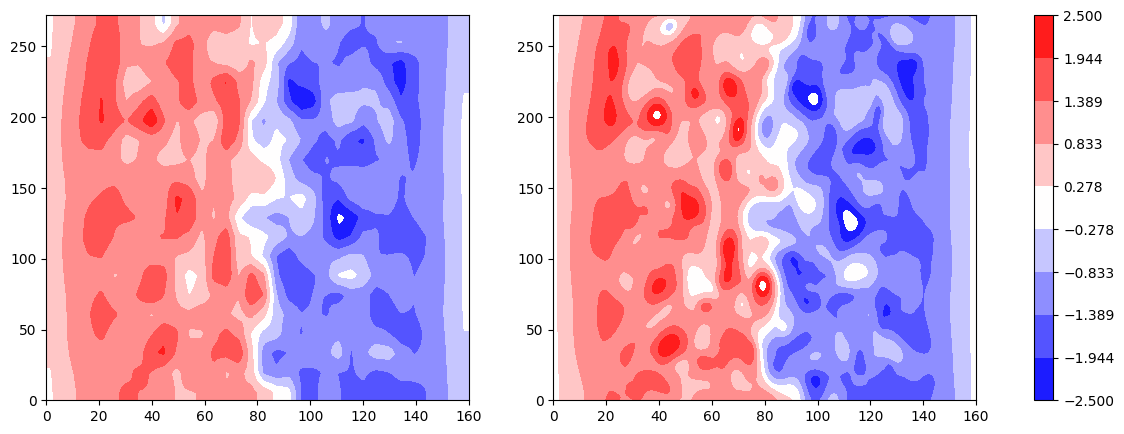

In [56]:
import torch.nn.functional as F
INPUT_DIM_X = 272
INPUT_DIM_Y = 160
DOWNGRADE_FACTOR = 8

p1 = data[-30][1][0] #First datapoint, phi1
lr_x = F.interpolate(p1.unsqueeze(0).unsqueeze(0), size=(INPUT_DIM_X//DOWNGRADE_FACTOR, INPUT_DIM_Y//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
print(lr_x[0][0].shape)
lr_x = F.interpolate(lr_x, size=(INPUT_DIM_X, INPUT_DIM_Y), mode='bilinear', align_corners=False)[0][0]
print(lr_x.shape)

fig, axs = plt.subplots(1,2,figsize = (15,5))

x = np.linspace(0, Nx, p.shape[0])
y = np.linspace(0, Ny, p.shape[1])
X, Y = np.meshgrid(x, y)
levels = np.linspace(-2.5, 2.5, 10)
# ax[i].set_cmap('bwr')
contour = axs[0].contourf(X, Y, np.transpose(lr_x), levels=levels, cmap = 'bwr')
contour = axs[1].contourf(X, Y, np.transpose(p1), levels=levels, cmap = 'bwr')
plt.colorbar(contour, ax=axs) #, label='Value')

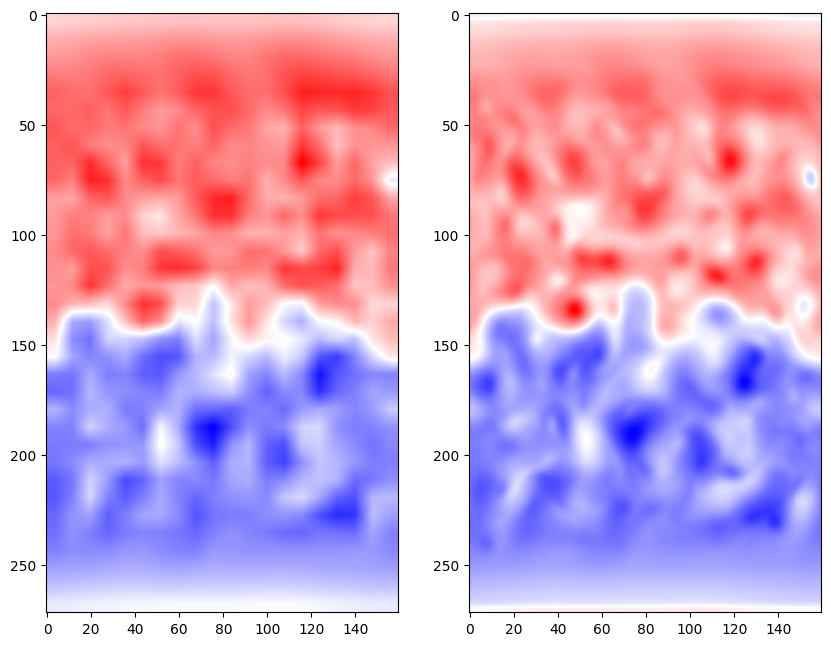

In [57]:
# plt.figure(figsize = (8,14))
fig, axs = plt.subplots(1,2, figsize = (10, 18))
axs[0].imshow(lr_x, cmap = 'bwr')
axs[1].imshow(p1, cmap = 'bwr')

In [27]:
path = "../data/raw/"
dataset = SinteticDataset(path, D = 150)

for i in tqdm(range(20)):
    for j in range(150):
        np.save(f"../data/processed/{i}_psi1_{j}.npy", dataset[i][j][0])
        np.save(f"../data/processed/{i}_psi2_{j}.npy", dataset[i][j][1])


100%|██████████| 20/20 [05:17<00:00, 15.86s/it]


In [22]:
dataset = SinteticDataset(path, D = 150)
dataset[0][5][0].shape

torch.Size([272, 160])

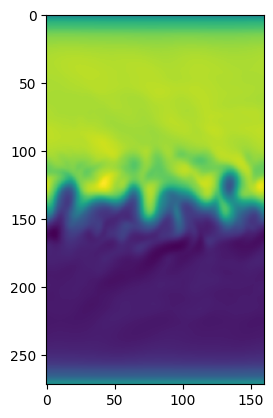

In [75]:
import os
path = os.listdir("../data/processed/")
i = np.random.choice(6000)
a = np.load("../data/processed/" + path[i])
plt.imshow(a)